# Emotions and CNN Project

Goal: create an CNN model which can predict the emotions and use your own pictures to actually recognize your emotions

In [25]:
# get the path of the current directory
path = os.getcwd()
path = os.path.join(path,'heavy')
print(path)

c:\Users\enric\Documents\projectsp\CNNEmotions\heavy


In [3]:
# Extracting the zipfile 
from zipfile import ZipFile

# specifity the name of the file
zippet = str("fer2013.csv.zip")

# open the zip file in read mode
with ZipFile(zippet, 'r') as zip:
    # list all the contents
    zip.printdir()

    # extract all the files
    print('extraction...')
    zip.extractall()
    print('Done!')

FileNotFoundError: [Errno 2] No such file or directory: 'heavy/fer2013.csv.zip'

Who can understand anything of this ? it is RGB images with 48x48 pixels. 

Can i trasfomr the 1st row into an image ? 

In [20]:
import pandas as pd

face = pd.read_csv('fer2013.csv')
face.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [21]:
# 1st row and the pixels image
face.loc[0,'pixels'];
# type(face.loc[0,'pixels'])
image1 = list(map(int, face.loc[0,'pixels'].split(" ")))
len(image1)

2304

as we can see the pixels are a 48x48 image since the len is 2304 = 48x48

class:  ndarray
shape:  (48, 48, 1)
strides:  (48, 1, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x18e704c7ea0
byteorder:  little
byteswap:  False
type: uint8


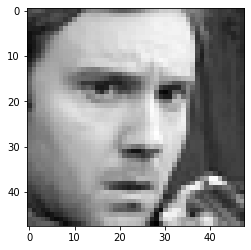

In [22]:
import re
import numpy as np
from PIL import Image
from pathlib import Path

# Open image file, slurp the lot
# contents = Path(image1).read_text()

width = 48;
height = 48;

# Make a list of anything that looks like numbers using a regex...
# ... taking first as height, second as width and remainder as pixels
# h, w *pixels = re.findall(r'[0-9]+', contents)

# Now make pixels into Numpy array of uint8 and reshape to correct height, width and depth
na = np.array(image1, dtype=np.uint8).reshape((int(48),int(48),1))

np.info(na);
# Now make the Numpy array into a PIL Image and save
#Image.fromarray(na).save("result.png")

from matplotlib import pyplot as plt
plt.imshow(na, cmap='gray')

ok, this dataset is in greyscale, so i need to go and download the original one ! at the folliwing site:

https://www.kaggle.com/datasets/deadskull7/fer2013

i was wrong. it is a greyscale images that i have to train in order to understand the emotions. Next step is to separete them into training and testing using the label in the 3rd column. 


In [5]:
print(face.loc[:,'Usage']);
face.groupby('Usage').count()

0           Training
1           Training
2           Training
3           Training
4           Training
            ...     
35882    PrivateTest
35883    PrivateTest
35884    PrivateTest
35885    PrivateTest
35886    PrivateTest
Name: Usage, Length: 35887, dtype: object


,emotion,pixels
Usage,,
PrivateTest,3589,3589
PublicTest,3589,3589
Training,28709,28709


let's place all the Public and Private test in the same test set and let's see how many classification emotions we have at the end, in order to see up the last layer with an appropriate number of nodes

In [60]:
""" def count(mylist):
    return len(set(myList))

print(count(face["emotion"]))   """     

len(set(face["emotion"]))

# so based on the result there are 7 different emotions

7

In [23]:
# Divide the training into training and test set
values = ['PublicTest', 'PrivateTest']
T = face[face['Usage'].isin(values) == False]

T.groupby('Usage').count();
T.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 0 to 28708
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
 2   Usage    28709 non-null  object
dtypes: int64(1), object(2)
memory usage: 897.2+ KB


In [30]:
# let's create the X_train in another way
new_pixels = []
print(type(T["pixels"]))
X_train = np.asarray(T["pixels"])

for row in X_train:
    row = np.asarray(list(map(int, row.split(" "))))
    new_pixels.append(row.reshape(48,48)) 

<class 'pandas.core.series.Series'>


In [31]:
new_pixels

[array([[ 70,  80,  82, ...,  52,  43,  41],
        [ 65,  61,  58, ...,  56,  52,  44],
        [ 50,  43,  54, ...,  49,  56,  47],
        ...,
        [ 91,  65,  42, ...,  72,  56,  43],
        [ 77,  82,  79, ..., 105,  70,  46],
        [ 77,  72,  84, ..., 106, 109,  82]]),
 array([[151, 150, 147, ..., 129, 140, 120],
        [151, 149, 149, ..., 122, 141, 137],
        [151, 151, 156, ..., 109, 123, 146],
        ...,
        [188, 188, 121, ..., 185, 185, 186],
        [188, 187, 196, ..., 186, 182, 187],
        [186, 184, 185, ..., 193, 183, 184]]),
 array([[231, 212, 156, ...,  44,  27,  16],
        [229, 175, 148, ...,  27,  35,  27],
        [214, 156, 157, ...,  28,  22,  28],
        ...,
        [241, 245, 250, ...,  57, 101, 146],
        [246, 250, 252, ...,  78, 105, 162],
        [250, 251, 250, ...,  88, 110, 152]]),
 array([[ 24,  32,  36, ..., 173, 172, 173],
        [ 25,  34,  29, ..., 173, 172, 173],
        [ 26,  29,  25, ..., 172, 172, 174],
        ..

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(new_pixels, T['emotion'], test_size=0.2, random_state=35)

## CNN to train this test set. 

Use a CNN neural network to predict the images

https://www.edureka.co/blog/convolutional-neural-network/

See 

In [33]:
print(face.loc[:,'Usage']);
face.groupby('Usage').count()

0           Training
1           Training
2           Training
3           Training
4           Training
            ...     
35882    PrivateTest
35883    PrivateTest
35884    PrivateTest
35885    PrivateTest
35886    PrivateTest
Name: Usage, Length: 35887, dtype: object


,emotion,pixels
Usage,,
PrivateTest,3589,3589
PublicTest,3589,3589
Training,28709,28709


In [26]:
nparr = list(map(int, X_train[0].split(" ")))

NameError: name 'X_train' is not defined

In [34]:
X_train

[array([[ 32,  29,  25, ...,  79,  71,  80],
        [ 32,  31,  26, ...,  58,  63,  56],
        [ 31,  35,  29, ...,  76,  80,  58],
        ...,
        [ 67,  67,  69, ...,  90, 123,  84],
        [ 67,  68,  70, ..., 102, 116,  70],
        [ 68,  68,  71, ..., 113,  99,  66]]),
 array([[118, 122, 126, ..., 141, 138, 136],
        [132, 139, 151, ..., 145, 142, 139],
        [116, 131, 145, ..., 147, 144, 141],
        ...,
        [ 63,  67,  70, ..., 143, 139, 133],
        [ 63,  67,  70, ..., 138, 133, 128],
        [ 61,  66,  69, ..., 132, 127, 122]]),
 array([[ 14,  14,  14, ...,  14,  14,  14],
        [ 12,  15,  17, ...,  13,  13,  15],
        [ 12,  13,  22, ...,  13,  13,  15],
        ...,
        [ 36, 149, 113, ...,  26,  25,  28],
        [105, 133,  85, ...,  28,  27,  36],
        [128,  92,  71, ...,  27,  32,  47]]),
 array([[ 73,  81,  97, ..., 226, 216, 221],
        [ 73,  86, 103, ..., 232, 214, 202],
        [ 84,  95, 112, ..., 232, 210, 174],
        ..

In [58]:
X_train = np.asarray(X_train)
type(X_train);
np.info(X_train)

class:  ndarray
shape:  (22967, 48, 48)
strides:  (9216, 192, 4)
itemsize:  4
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x18e32cb0040
byteorder:  little
byteswap:  False
type: int32


In [64]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [65]:
model = Sequential()
# take as input 
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (48,48,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation = "softmax"))

In [66]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [73]:
# Compile the model
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

# sparse_categorical_crossentropy = essential for multiple classification

In [74]:
epochs = 10  # for better result increase the epochs
batch_size = 250

### Data Augmentation
To avoid overfitting problem, we need to expand artificially our handwritten digit dataset
Alter the training data with small transformations to reproduce the variations of digit.

In [69]:
""" datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
 """
# datagen.fit(X_train)

' datagen = ImageDataGenerator(\n        featurewise_center=False,  # set input mean to 0 over the dataset\n        samplewise_center=False,  # set each sample mean to 0\n        featurewise_std_normalization=False,  # divide inputs by std of the dataset\n        samplewise_std_normalization=False,  # divide each input by its std\n        zca_whitening=False,  # dimesion reduction\n        rotation_range=5,  # randomly rotate images in the range 5 degrees\n        zoom_range = 0.1, # Randomly zoom image 10%\n        width_shift_range=0.1,  # randomly shift images horizontally 10%\n        height_shift_range=0.1,  # randomly shift images vertically 10%\n        horizontal_flip=False,  # randomly flip images\n        vertical_flip=False)  # randomly flip images\n '

You need to add a channel dimension. Keras expects this data format:

(n_samples, height, width, channels)
For instance this, if your images are greyscale, they have 1 channel, and so they need to be given to Keras in this format:

(60000, 28, 28, 1)

In [70]:
X_train = X_train.reshape(-1, 48, 48, 1)

In [75]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 8)         208       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               590080    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

Since i just started using CNN and deep learning i am just going empirically forward. I know there is ealry stopping and overtraining but 1st let train a model and see the result. 

Let's try to explain the loss and the accuracy parameters you see below

The lower the loss, the better a model (unless the model has over-fitted to the training data). The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets.

The accuracy of a model is usually determined after the model parameters are learned and fixed and no learning is taking place. Then the test samples are fed to the model and the number of mistakes (zero-one loss) the model makes are recorded, after comparison to the true targets. Then the percentage of misclassification is calculated.

In [77]:
# Fit the model
""" history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size) """

model.fit(X_train, y_train, batch_size=12,epochs=40, verbose=1)


Epoch 1/40
1180/1914 [=================>............] - ETA: 10s - loss: 0.8708 - accuracy: 0.6769